In [1]:
%autosave 30
from IPython.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))
import importlib as imp
import utils_models as fx
import glob

Autosaving every 30 seconds


### Training models in a loop
- Run this cell only if models have not already been trained
- Otherwise move to next cell (models are only loaded, not trained)

In [ ]:
run_from_scratch = False
imp.reload(fx)
import gc
pattern = '*.pkl'
matching_files = glob.glob(pattern)
names_dict = {}
times_dict = {}

if run_from_scratch: 
    for file_path in matching_files:
        file_name = file_path.split("/")[-1]
        NAME = file_path.split('_')[0]
        TIME = file_path.split('_')[1]  # Remove the file extension
        if NAME not in names_dict:
            names_dict[NAME] = []
        if NAME not in times_dict:
            times_dict[NAME] = []
        names_dict[NAME].append(TIME)
        times_dict[NAME].append(TIME) 


    name_time_list = []
    for name, times in times_dict.items():
        for time in times:
            name_time_list.append((name, time))

    names_to_test = set([i for i,_ in name_time_list])

    for name_testing_subject in names_to_test:
        print(f'================={name_testing_subject}=================')
        try: 
            del testing_data, training_data, testing_states, training_states
            gc.collect()
        except:
            pass

        testing_data = []; training_data = [] 
        testing_states = []; training_states = []
        print('Organizing data...')

        for name, time in name_time_list:

            #read data
            data, states = fx.read_data_and_metadata(name, time, best_channel=True)

            if name == name_testing_subject:
                testing_data.append(data)
                testing_states.extend(states)
            else:
                training_data.append(data)
                training_states.extend(states)

        testing_data = np.concatenate(testing_data, axis=0)
        training_data = np.concatenate(training_data, axis=0)

        print('Building Model 1...')
        treshold_mod1 = 0.9
        cm1, unknown_counts1 = fx.model1(name_testing_subject, 
                                         training_data, 
                                         training_states, 
                                         testing_data, 
                                         testing_states, 
                                         treshold_mod1,
                                         norm=True)  # if normalize_data = False, means that we normalize it across subject BEFORE loop across subjects!!!

        print('Building Model 2...')
        treshold_mod2 = 0.85
        fx.mod2(name_testing_subject, training_data, training_states, testing_data, testing_states, treshold_mod2, norm=True)

### Models are already trained
This cell allows you to load the trained models on each subject (classical leave-one-out) and save the corresponding data and labels for further processing

In [ ]:
imp.reload(fx)
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import gc
pattern = '*.pkl'
matching_files = glob.glob(pattern)
names_dict = {}
times_dict = {}

for file_path in matching_files:
    file_name = file_path.split("/")[-1]
    NAME = file_path.split('_')[0]
    TIME = file_path.split('_')[1]  # Remove the file extension
    if NAME not in names_dict:
        names_dict[NAME] = []
    if NAME not in times_dict:
        times_dict[NAME] = []
    names_dict[NAME].append(TIME)
    times_dict[NAME].append(TIME)

    
name_time_list = []
for name, times in times_dict.items():
    for time in times:
        if name != 'metrics':
            name_time_list.append((name, time))
        
names_to_test = set([i for i,_ in name_time_list])
names_to_test = ['Monica', 'Natasha', 'Phoebe', 'Skipper']

for name_testing_subject in names_to_test:
    print(f'================={name_testing_subject}=================')
    try: 
        del testing_data, training_data, testing_states, training_states
        gc.collect()
    except:
        pass

    testing_data = []; training_data = [] 
    testing_states = []; training_states = []
    print('Organizing data...')

    for name, time in name_time_list:

        #read data
        data, states = fx.read_data_and_metadata(name, time, best_channel=True)

        if name == name_testing_subject:
            testing_data.append(data)
            testing_states.extend(states)
        else:
            training_data.append(data)
            training_states.extend(states)

    testing_data = np.concatenate(testing_data, axis=0)
    training_data = np.concatenate(training_data, axis=0)
    model = fx.CNN()
    model_path = f"models_trainmain/primary_model_epoch_{name_testing_subject}_6.pth"
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded model from {model_path}")
    
    test_data_normalized = fx.normalize_data(testing_data)
    test_labels_numeric = fx.labels_to_numbers(testing_states)
    test_dataset = TensorDataset(torch.tensor(test_data_normalized, dtype=torch.float32).unsqueeze(1),
                                 torch.tensor(test_labels_numeric, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    all_preds, all_labels = [], []
    all_preds_prob, all_labels_prob = [], []
    probs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, preds_prob = torch.max(probabilities, 1)
            # preds[probabilities.max(dim=1).values < treshold_mod1] = -1
            all_preds_prob.extend(preds_prob.cpu().numpy())
            all_labels_prob.extend(labels.numpy())
            probs.append(list(probabilities.numpy()[0]))

    df_pred = pd.DataFrame({'all_preds_prob': all_preds_prob, 'all_labels_prob': all_labels_prob, 'prob': probs})
    df_pred.to_pickle(f'model_df_probs/df_pred_model1_{name_testing_subject}')        

    treshold_mod2 = 0.85
    y_pred, predictions, true_classes, data_test_MA, labels_test_MA = fx.mod2(name_testing_subject, training_data, training_states, testing_data, testing_states, treshold_mod2, LEAVEONEOUT, norm=True) 
    
    # apppend to dataframe
    df_pred = pd.DataFrame({'y_pred': y_pred.reshape(1, -1)[0], 'predictions': predictions.reshape(1, -1)[0], 'true_classes': true_classes})
    df_pred.to_pickle(f'model_df_probs/df_pred_model2_{name_testing_subject}_loo')
        
    # save testing data
    np.save(f'testing_data/testing_data_{name_testing_subject}.npy', testing_data)
    np.save(f'testing_data/testing_labels_{name_testing_subject}.npy', testing_states)
    np.save(f'testing_data/testing_dataMA_{name_testing_subject}.npy', data_test_MA)
    np.save(f'testing_data/testing_labelsMA_{name_testing_subject}.npy', labels_test_MA)


### Threshold analysis
The cell below allows you to perform an analysis of the accuracy with respect to the confidence threshold used.
- If a sample is below the confindence threshold, it is labelled as unknown and needs further processing. 
- In the case of asynch_MA and slow_MA, the confidence threshold is thr and 1-th respectively, where `x` in `1-thr <= x <= thr` is labelled as unknown, being `thr > 0.5`

In [ ]:
confusion_matrix(df_pred['all_labels_prob'], df_pred['y_prob'], labels=[0, 1, 2])

In [2]:
import os
import pickle
import pandas as pd
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

pattern = '*.pkl'
matching_files = glob.glob(pattern)
matching_files = [i for i in matching_files if not i.startswith('metrics')]
names_dict = {}
times_dict = {}

for file_path in matching_files:
    file_name = file_path.split("/")[-1]
    NAME = file_path.split('_')[0]
    TIME = file_path.split('_')[1]  # Remove the file extension
    if NAME not in names_dict:
        names_dict[NAME] = []
    if NAME not in times_dict:
        times_dict[NAME] = []
    names_dict[NAME].append(TIME)
    times_dict[NAME].append(TIME)

    
name_time_list = []
for name, times in times_dict.items():
    for time in times:
        name_time_list.append((name, time))
        
names_to_test = set([i for i,_ in name_time_list])


df_acc = pd.DataFrame(columns=['sub', 'state', 'value', 'thr', 'to_unknown', 'to_unknown_notnorm', 'num_samples_state'])
df_acc_MA = pd.DataFrame(columns=['sub', 'state', 'value', 'thr', 'to_unknown', 'to_unknown_notnorm', 'num_samples_state'])
df_acc_wUK = pd.DataFrame(columns=['sub', 'state', 'value', 'thr', 'num_samples_state'])
df_acc_MA_wUK = pd.DataFrame(columns=['sub', 'state', 'value', 'thr', 'num_samples_state'])
# initialize precision, recall and f1score df
df_metrics = pd.DataFrame(columns=['sub', 'model', 'thr', 'precision', 'recall', 'f1'])
df_metrics_nounknown = pd.DataFrame(columns=['sub', 'model', 'thr', 'precision', 'recall', 'f1'])

for threshold in np.arange(0.4, 1.0, 0.05):
    clear_output()
    print(f'Threshold: {threshold}')
    thr = [threshold, threshold]
    
    for name_testing_subject in ['Skipper', 'Monica', 'Phoebe', 'Natasha']: # names_to_test:
        
        # read dataframe for model 1
        df_pred = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model1_{name_testing_subject}')

        # apply threshold filter
        df_pred['y_prob'] = [df_pred['all_preds_prob'].iloc[p] if np.max(df_pred['prob'].iloc[p]) > thr[0] else -1 for p in range(len(df_pred['prob']))]

        # compute confusion matrix
        cm = confusion_matrix(df_pred['all_labels_prob'], df_pred['y_prob'], labels=[0, 1, 2, -1])
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        with open(f'testing_data/cm_model1_{name_testing_subject}_thr_{np.round(thr[0],2)}.pkl', "wb") as pickle_file:
            pickle.dump({'cm': cm, 'cm_n': cm_normalized}, pickle_file)
            
        # compute confusion matrix WITHOUT UNKNOWNS
        cm_wUK = confusion_matrix(df_pred['all_labels_prob'], df_pred['y_prob'], labels=[0, 1, 2])
        cm_normalized_wUK = cm_wUK.astype('float') / cm_wUK.sum(axis=1)[:, np.newaxis]
        
        with open(f'testing_data/cm_wUK_model1_{name_testing_subject}_thr_{np.round(thr[0],2)}.pkl', "wb") as pickle_file:
            pickle.dump({'cm': cm_wUK, 'cm_n': cm_normalized_wUK}, pickle_file)

        # compute accuracy dataframe including unknowns
        state_dict = {0: 'AW', 1: 'SO', 2: 'MA', -1: 'unknown'}
        for i in state_dict.keys():
            # append to df
            df_acc = pd.concat([df_acc, pd.DataFrame({
                'sub': name_testing_subject, 
                'state': state_dict[i], 
                'value': [cm_normalized[i, i]],
                'thr': [np.round(thr[0],2)],
                'to_unknown': [cm_normalized[i, -1]],
                'to_unknown_notnorm': [cm[i, -1]],
                'num_samples_state': [np.sum(cm[i, :])],
            })], ignore_index=True)
            
        # compute accuracy dataframe excluding unknowns
        state_dict_wUK = {0: 'AW', 1: 'SO', 2: 'MA'}
        for i in state_dict_wUK.keys():
            # append to df
            df_acc_wUK = pd.concat([df_acc_wUK, pd.DataFrame({
                'sub': name_testing_subject, 
                'state': state_dict_wUK[i], 
                'value': [cm_normalized_wUK[i, i]],
                'thr': [np.round(thr[0],2)],
                'num_samples_state': [np.sum(cm_wUK[i, :])],
            })], ignore_index=True)
            
        # get metrics for precision, recall and f1
        df_metrics = pd.concat([df_metrics, pd.DataFrame({
            'sub': name_testing_subject, 
            'model': [1], 
            'thr': [thr[0]],
            'precision': [precision_score(df_pred['all_labels_prob'], df_pred['y_prob'], average='macro')], 
            'recall': [recall_score(df_pred['all_labels_prob'], df_pred['y_prob'], average='macro')], 
            'f1': [f1_score(df_pred['all_labels_prob'], df_pred['y_prob'], average='macro')],
        })], ignore_index=True)
        
        # do the same metrics but without taking into account unknowns
        val_nounknowns = df_pred.loc[df_pred['y_prob']!=-1].index.values
        df_metrics_nounknown = pd.concat([df_metrics_nounknown, pd.DataFrame({
            'sub': name_testing_subject, 
            'model': [1], 
            'thr': [thr[0]],
            'precision': [precision_score(df_pred['all_labels_prob'].iloc[val_nounknowns], df_pred['y_prob'].iloc[val_nounknowns], average='macro')], 
            'recall': [recall_score(df_pred['all_labels_prob'].iloc[val_nounknowns], df_pred['y_prob'].iloc[val_nounknowns], average='macro')], 
            'f1': [f1_score(df_pred['all_labels_prob'].iloc[val_nounknowns], df_pred['y_prob'].iloc[val_nounknowns], average='macro')],
        })], ignore_index=True)


        # read df model 2
        df_mod2 = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model2_{name_testing_subject}')

        # threshold
        predicted_classes = np.where(df_mod2['predictions'] > thr[1], 1, 
                                     np.where(df_mod2['predictions'] <= 1 - thr[1], 0, -1)).flatten()
        
        # compute confusion matrix
        cm = confusion_matrix(df_mod2['true_classes'], predicted_classes, labels=[0, 1, -1])
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        with open(f'testing_data/cm_model2_{name_testing_subject}_thr_{np.round(thr[1],2)}.pkl', "wb") as pickle_file:
            pickle.dump({'cm': cm, 'cm_n': cm_normalized}, pickle_file)
            
        # compute confusion matrix WITHOUT UNKNOWNS
        cm_wUK = confusion_matrix(df_mod2['true_classes'], predicted_classes, labels=[0, 1])
        cm_normalized_wUK = cm_wUK.astype('float') / cm_wUK.sum(axis=1)[:, np.newaxis]
        with open(f'testing_data/cm_wUK_model2_{name_testing_subject}_thr_{np.round(thr[1],2)}.pkl', "wb") as pickle_file:
            pickle.dump({'cm': cm_wUK, 'cm_n': cm_normalized_wUK}, pickle_file)

        
        df_metrics = pd.concat([df_metrics, pd.DataFrame({
            'sub': name_testing_subject, 
            'model': [2], 
            'thr': [thr[1]],
            'precision': [precision_score(df_mod2['true_classes'], predicted_classes, average='macro')], 
            'recall': [recall_score(df_mod2['true_classes'], predicted_classes, average='macro')], 
            'f1': [f1_score(df_mod2['true_classes'], predicted_classes, average='macro')],
        })], ignore_index=True)
        
        # do the same metrics but without taking into account unknowns
        val_nounknowns_mod2 = np.where(predicted_classes!=-1)[0]        
        df_metrics_nounknown = pd.concat([df_metrics_nounknown, pd.DataFrame({
            'sub': name_testing_subject, 
            'model': [2], 
            'thr': [thr[1]],
            'precision': [precision_score(df_mod2['true_classes'].iloc[val_nounknowns_mod2], predicted_classes[val_nounknowns_mod2], average='macro')], 
            'recall': [recall_score(df_mod2['true_classes'].iloc[val_nounknowns_mod2], predicted_classes[val_nounknowns_mod2], average='macro')], 
            'f1': [f1_score(df_mod2['true_classes'].iloc[val_nounknowns_mod2], predicted_classes[val_nounknowns_mod2], average='macro')],
        })], ignore_index=True)
        
        # compute accuracy dataframe including unknowns
        state_dict_mod2 = {0: 'asynch_MA', 1: 'slow_MA', -1:'unknown'}
        for i in state_dict_mod2.keys():
            # append to df
            df_acc_MA = pd.concat([df_acc_MA, pd.DataFrame({
                'sub': name_testing_subject, 
                'state': state_dict_mod2[i], 
                'value': [cm_normalized[i, i]],
                'thr': [np.round(thr[1],2)],
                'to_unknown': [cm_normalized[i, -1]],
                'to_unknown_notnorm': [cm[i, -1]],
                'num_samples_state': [np.sum(cm[i, :])],
            })], ignore_index=True)
        
        # compute accuracy dataframe excluding unknowns
        state_dict_mod2_wUK = {0: 'asynch_MA', 1: 'slow_MA'}
        for i in state_dict_mod2_wUK.keys():
            # append to df
            df_acc_MA_wUK = pd.concat([df_acc_MA_wUK, pd.DataFrame({
                'sub': name_testing_subject, 
                'state': state_dict_mod2_wUK[i], 
                'value': [cm_normalized_wUK[i, i]],
                'thr': [np.round(thr[1],2)],
                'num_samples_state': [np.sum(cm_wUK[i, :])],
            })], ignore_index=True)
        

Threshold: 0.9499999999999998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site

### Compute percentage (all subjects) of samples going to uknown
- These unknown samples will undergo further processing (AE + centroids)

In [3]:
# define threshold
thr = 0.9

df_acc_thr = df_acc.loc[df_acc['thr']==thr]
df_acc_MA_thr = df_acc_MA.loc[df_acc_MA['thr']==thr]

# the above cell needs to be executed only for the 4 subjects and for threshold 0.9
print(f"Model 1: The number of unknowns is {np.round(100* df_acc_thr['to_unknown_notnorm'].values.sum() / df_acc_thr['num_samples_state'].values.sum(), 2)}% of the total number of samples")
print(f"Model 2: The number of unknowns is {np.round(100* df_acc_MA_thr['to_unknown_notnorm'].values.sum() / df_acc_MA_thr['num_samples_state'].values.sum(), 2)}% of the total number of samples")

for state in [i for i in set(df_acc_thr['state']) if i != 'unknown']:
    print(f"Model 1 {state}: {np.round(100* df_acc_thr.loc[df_acc_thr['state']==state]['to_unknown_notnorm'].values.sum() / df_acc_thr.loc[df_acc_thr['state']==state]['num_samples_state'].values.sum(), 2)}%")

for state in [i for i in set(df_acc_MA_thr['state']) if i != 'unknown']:
    print(f"Model 2 {state}: {np.round(100* df_acc_MA_thr.loc[df_acc_MA_thr['state']==state]['to_unknown_notnorm'].values.sum() / df_acc_MA_thr.loc[df_acc_MA_thr['state']==state]['num_samples_state'].values.sum(), 2)}%")

Model 1: The number of unknowns is 8.01% of the total number of samples
Model 2: The number of unknowns is 29.96% of the total number of samples
Model 1 MA: 5.66%
Model 1 AW: 13.12%
Model 1 SO: 9.4%
Model 2 slow_MA: 38.3%
Model 2 asynch_MA: 22.59%


### Figure: Unknown percentage as a function of the threshold
- For each subject and state, compute the percentage of unknowns with respect to the confidence threshold used
- As expected, the higher the condifence threshold the higher the number of unknowns

<IPython.core.display.Javascript object>


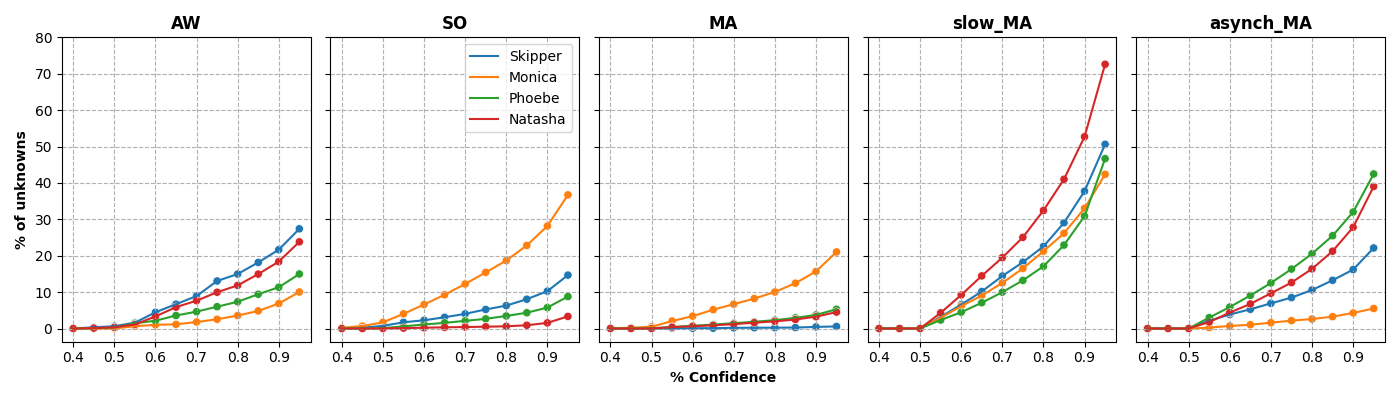

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(ncols=5, figsize=(14, 4), sharex=True, sharey=True)
leg_viz = False
for sdx, state in enumerate(['AW', 'SO', 'MA']):
    leg_viz = True if sdx == 1 else False
    sns.lineplot(data=df_acc.loc[df_acc['state']==state], x='thr', y='to_unknown', hue='sub', ax=ax[sdx], legend=leg_viz)
    sns.scatterplot(data=df_acc.loc[df_acc['state']==state], x='thr', y='to_unknown', hue='sub', ax=ax[sdx], legend=False)
    ax[sdx].set_title(f'{state}', fontweight='bold')
    ax[sdx].set_xlabel('')
    ax[sdx].grid(linestyle='--')
    if leg_viz: 
        ax[sdx].legend(loc=1)

for sdx, state in enumerate(['slow_MA', 'asynch_MA']):
    sns.lineplot(data=df_acc_MA.loc[df_acc_MA['state']==state], x='thr', y='to_unknown', hue='sub', ax=ax[sdx+3], legend=False)
    sns.scatterplot(data=df_acc_MA.loc[df_acc_MA['state']==state], x='thr', y='to_unknown', hue='sub', ax=ax[sdx+3], legend=False)
    ax[sdx + 3].set_title(f'{state}', fontweight='bold')
    ax[sdx + 3].set_xlabel('')
    ax[sdx + 3].grid(linestyle='--')


# fig.suptitle()
ax[sdx].set_yticks([0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8])
ax[0].set_yticklabels([int(i*100) for i in ax[0].get_yticks()])
ax[0].set_ylabel('% of unknowns', fontweight='bold')
ax[0].set_xticks(np.arange(0.4, 1.0, 0.1))
ax[2].set_xlabel('% Confidence', fontweight='bold')
plt.tight_layout()
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\unknowns_percentage.jpg')
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\unknowns_percentage.svg', dpi=600)

### Figure: Accuracies of state dependant of the threshold INCLUDING UNKNOWNS
- Plot of the accuracies obtained (by state and subject) when choosing different confidence thresholds

<IPython.core.display.Javascript object>


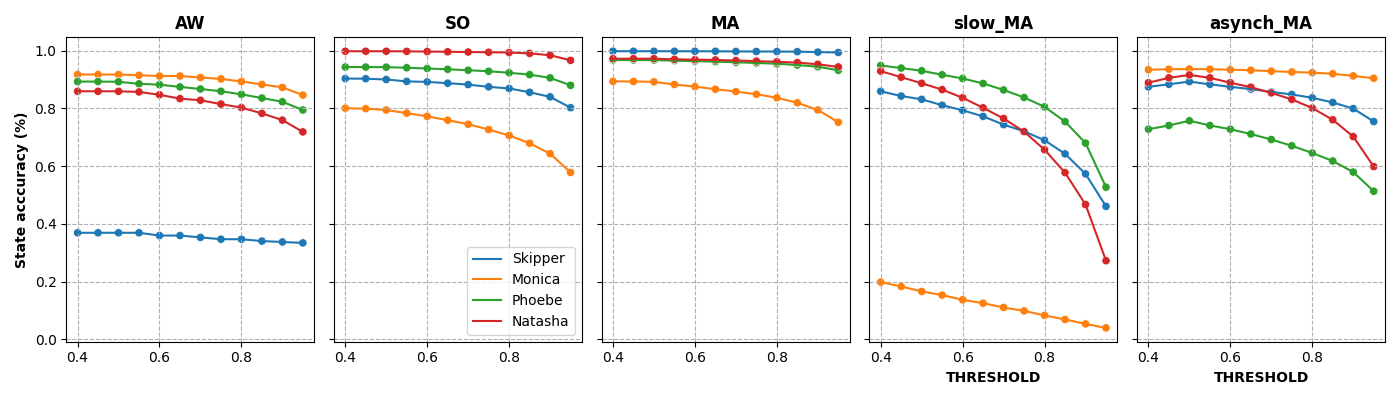

In [12]:
fig, ax = plt.subplots(ncols=5, figsize=(14, 4), sharex=False, sharey=True)
for sdx, state in enumerate(['AW', 'SO', 'MA']):
    leg_viz = True if sdx == 1 else False
    sns.lineplot(data=df_acc.loc[df_acc['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx], legend=leg_viz)
    sns.scatterplot(data=df_acc.loc[df_acc['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx], legend=False)
    ax[sdx].set_title(f'{state}', fontweight='bold')
    ax[sdx].set_xlabel('')
    ax[sdx].grid(linestyle='--')
    if leg_viz: 
        ax[sdx].legend(loc=4)

for sdx, state in enumerate(['slow_MA', 'asynch_MA']):
    sns.lineplot(data=df_acc_MA.loc[df_acc_MA['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx+3], legend=False)
    sns.scatterplot(data=df_acc_MA.loc[df_acc_MA['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx+3], legend=False)
    ax[sdx+3].set_title(f'{state}', fontweight='bold')
    ax[sdx+3].set_xlabel('THRESHOLD', fontweight='bold')
    ax[sdx+3].grid(linestyle='--')

ax[0].set_ylabel('State acccuracy (%)', fontweight='bold')
plt.tight_layout()

### Figure: Accuracies of state dependant of the threshold EXCLUDING UNKNOWNS
- Plot of the accuracies obtained (by state and subject) when choosing different confidence thresholds

<IPython.core.display.Javascript object>


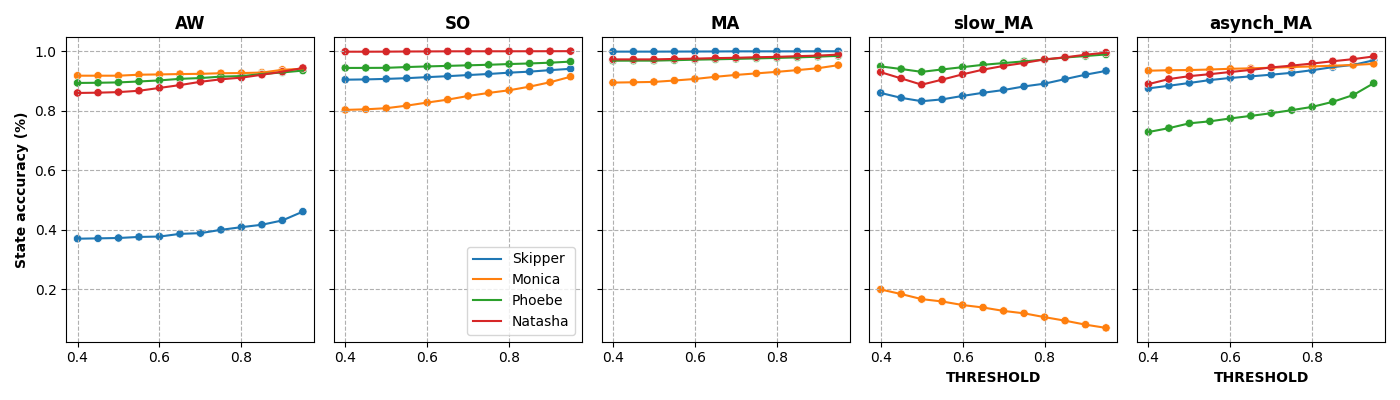

In [15]:
fig, ax = plt.subplots(ncols=5, figsize=(14, 4), sharex=False, sharey=True)
for sdx, state in enumerate(['AW', 'SO', 'MA']):
    leg_viz = True if sdx == 1 else False
    sns.lineplot(data=df_acc_wUK.loc[df_acc_wUK['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx], legend=leg_viz)
    sns.scatterplot(data=df_acc_wUK.loc[df_acc_wUK['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx], legend=False)
    ax[sdx].set_title(f'{state}', fontweight='bold')
    ax[sdx].set_xlabel('')
    ax[sdx].grid(linestyle='--')
    if leg_viz: 
        ax[sdx].legend(loc=4)

for sdx, state in enumerate(['slow_MA', 'asynch_MA']):
    sns.lineplot(data=df_acc_MA_wUK.loc[df_acc_MA_wUK['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx+3], legend=False)
    sns.scatterplot(data=df_acc_MA_wUK.loc[df_acc_MA_wUK['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx+3], legend=False)
    ax[sdx+3].set_title(f'{state}', fontweight='bold')
    ax[sdx+3].set_xlabel('THRESHOLD', fontweight='bold')
    ax[sdx+3].grid(linestyle='--')

ax[0].set_ylabel('State acccuracy (%)', fontweight='bold')
plt.tight_layout()

In [ ]:
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\accuracies_threshold_without_UNKNOWNS.svg', dpi=600)

### Figure: Confusion Matrices without confidence level INCLUDING UNKNOWNS
- Plot the confusion matrices for all states and subjects given a confidence threshold `thr`

<IPython.core.display.Javascript object>


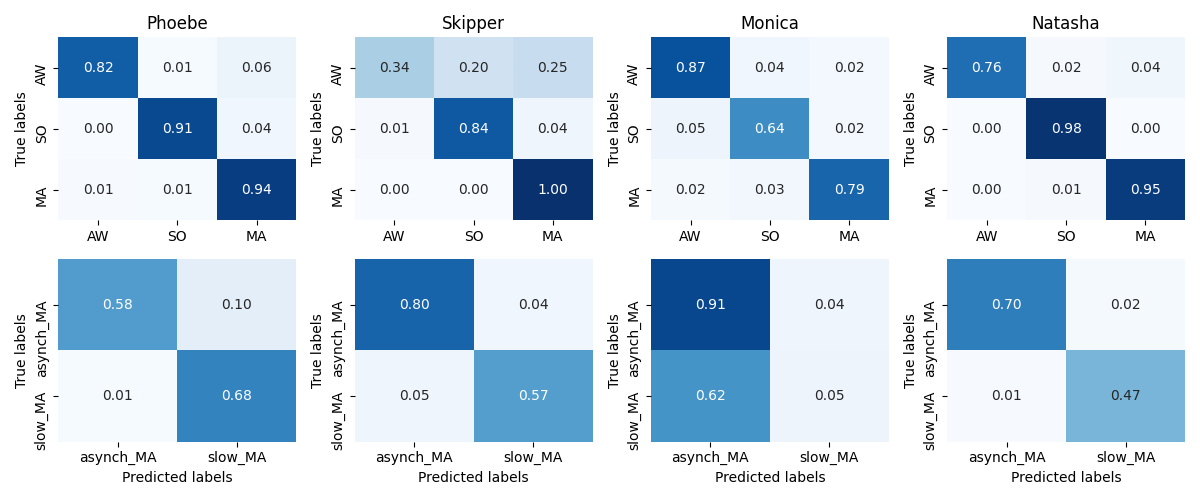

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
# choose confidence threshold
thr = 0.9

cm_avg_mod1 = np.array([])
cm_avg_mod2 = np.array([])

### ONLY GOOD SUBJECTS
names_to_test_good = [i for i in names_to_test if any([i.startswith(j) for j in ['Phoebe', 'Monica', 'Natasha', 'Skipper']])]

fig, ax = plt.subplots(nrows=2, ncols=len(names_to_test_good), figsize=(12, 5))
for sdx, name_testing_subject in enumerate(names_to_test_good):
    with open(f'testing_data/cm_model1_{name_testing_subject}_thr_{thr}.pkl', "rb") as pickle_file:
        conf = pickle.load(pickle_file)
    
    cm_normalized = conf['cm_n']
    classes = ['AW', 'SO', 'MA']
    sns.heatmap(cm_normalized[:3, :3], annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[0, sdx], cbar=False, vmin=0, vmax=1)
    ax[0, sdx].set_xlabel('')
    ax[0, sdx].set_ylabel('True labels')
    ax[0, sdx].set_title(name_testing_subject)
    
    cm_avg_mod1 = np.vstack([cm_avg_mod1, [cm_normalized[:3, :3]]]) if cm_avg_mod1.size else np.array([cm_normalized[:3, :3]])
    
    with open(f'testing_data/cm_model2_{name_testing_subject}_thr_{thr}.pkl', "rb") as pickle_file:
        conf2 = pickle.load(pickle_file)
    
    cm_normalized = conf2['cm_n']
    classes = ['asynch_MA', 'slow_MA']
    sns.heatmap(cm_normalized[:2, :2], annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[1, sdx], cbar=False, vmin=0, vmax=1)
    ax[1, sdx].set_xlabel('Predicted labels')
    ax[1, sdx].set_ylabel('True labels')
    
    cm_avg_mod2 = np.vstack([cm_avg_mod2, [cm_normalized[:2, :2]]]) if cm_avg_mod2.size else np.array([cm_normalized[:2, :2]])
    
plt.tight_layout()

### Figure: Average of Confusion Matrices without confidence level INCLUDING UNKNOWNS
- Plot the subject-averaged accuracies for the three major states (AW, SO , MA)

<IPython.core.display.Javascript object>


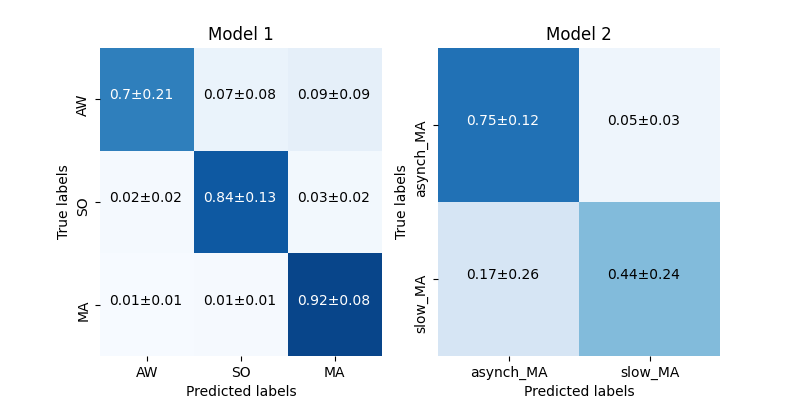

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
classes = ['AW', 'SO', 'MA']
sns.heatmap(np.mean(cm_avg_mod1, axis=0), annot=False, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[0], cbar=False, vmin=0, vmax=1)
ax[0].set_xlabel('Predicted labels')
for i in range(3):
    for j in range(3):
        val_mean = np.round(np.mean(cm_avg_mod1, axis=0)[j, i], 2)
        val_std = np.round(np.std(cm_avg_mod1, axis=0)[j, i], 2)
        ax[0].text(i+0.1, j+0.5, f'{val_mean}±{val_std}', c='k' if val_mean < 0.5 else 'w')

classes = ['asynch_MA', 'slow_MA']
sns.heatmap(np.mean(cm_avg_mod2, axis=0), annot=False, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[1], cbar=False, vmin=0, vmax=1)
ax[0].set_ylabel('True labels')
ax[1].set_ylabel('True labels')
ax[0].set_title('Model 1')
ax[1].set_title('Model 2')
ax[1].set_xlabel('Predicted labels')
for i in range(2):
    for j in range(2):
        val_mean = np.round(np.mean(cm_avg_mod2, axis=0)[j, i], 2)
        val_std = np.round(np.std(cm_avg_mod2, axis=0)[j, i], 2)
        ax[1].text(i+0.2, j+0.5, f'{val_mean}±{val_std}', c='k' if val_mean < 0.5 else 'w')

In [ ]:
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\model1model2_accuracies.svg', dpi=600)

### Figure: Confusion Matrices without confidence level EXCLUDING UNKNOWNS
- Plot the confusion matrices for all states and subjects given a confidence threshold `thr`

<IPython.core.display.Javascript object>


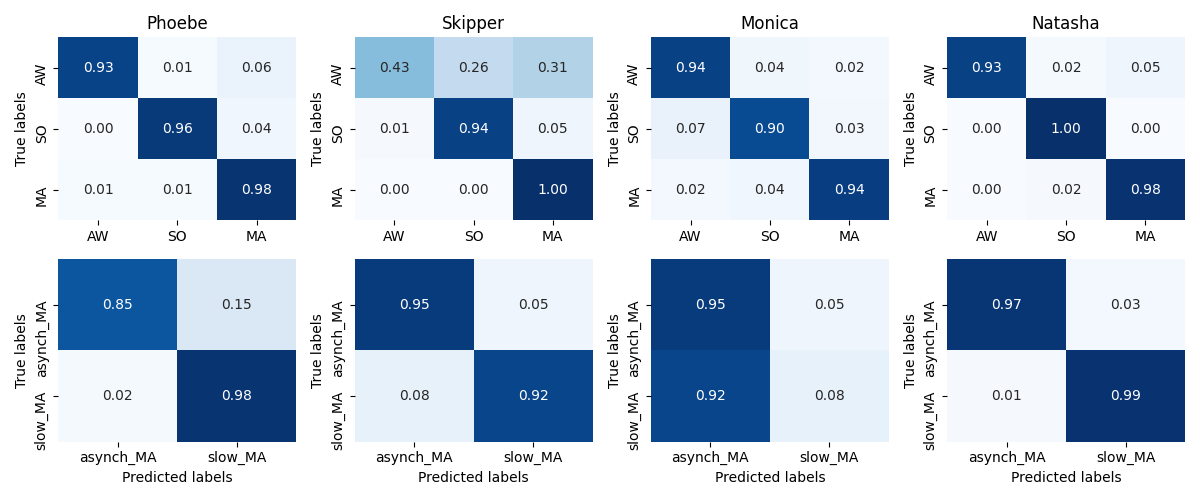

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# choose confidence threshold
thr = 0.9

cm_avg_mod1_wUK = np.array([])
cm_avg_mod2_wUK = np.array([])

### ONLY GOOD SUBJECTS
names_to_test_good = [i for i in names_to_test if any([i.startswith(j) for j in ['Phoebe', 'Monica', 'Natasha', 'Skipper']])]

fig, ax = plt.subplots(nrows=2, ncols=len(names_to_test_good), figsize=(12, 5))
for sdx, name_testing_subject in enumerate(names_to_test_good):
    with open(f'testing_data/cm_wUK_model1_{name_testing_subject}_thr_{thr}.pkl', "rb") as pickle_file:
        conf = pickle.load(pickle_file)
    
    cm_normalized = conf['cm_n']
    classes = ['AW', 'SO', 'MA']
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[0, sdx], cbar=False, vmin=0, vmax=1)
    ax[0, sdx].set_xlabel('')
    ax[0, sdx].set_ylabel('True labels')
    ax[0, sdx].set_title(name_testing_subject)
    
    cm_avg_mod1_wUK = np.vstack([cm_avg_mod1_wUK, [cm_normalized]]) if cm_avg_mod1_wUK.size else np.array([cm_normalized])
    
    with open(f'testing_data/cm_wUK_model2_{name_testing_subject}_thr_{thr}.pkl', "rb") as pickle_file:
        conf2 = pickle.load(pickle_file)
    
    cm_normalized = conf2['cm_n']
    classes = ['asynch_MA', 'slow_MA']
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[1, sdx], cbar=False, vmin=0, vmax=1)
    ax[1, sdx].set_xlabel('Predicted labels')
    ax[1, sdx].set_ylabel('True labels')
    
    cm_avg_mod2_wUK = np.vstack([cm_avg_mod2_wUK, [cm_normalized]]) if cm_avg_mod2_wUK.size else np.array([cm_normalized])
    
plt.tight_layout()

### Figure: Average of Confusion Matrices without confidence level EXCLUDING UNKNOWNS
- Plot the subject-averaged accuracies for the three major states (AW, SO , MA)

<IPython.core.display.Javascript object>


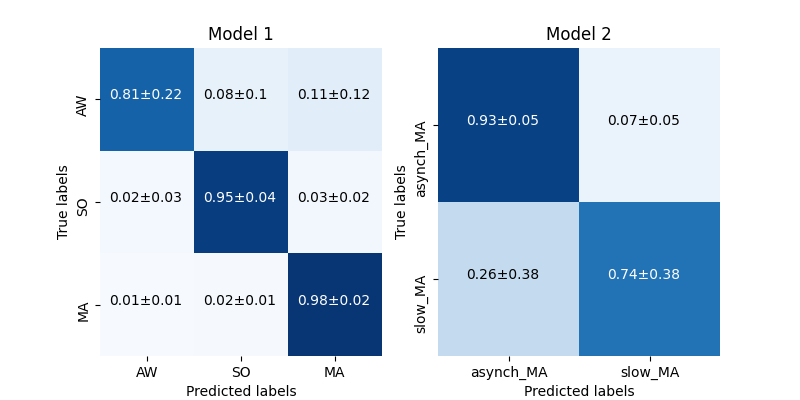

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
classes = ['AW', 'SO', 'MA']
sns.heatmap(np.mean(cm_avg_mod1_wUK, axis=0), annot=False, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[0], cbar=False, vmin=0, vmax=1)
ax[0].set_xlabel('Predicted labels')
for i in range(3):
    for j in range(3):
        val_mean = np.round(np.mean(cm_avg_mod1_wUK, axis=0)[j, i], 2)
        val_std = np.round(np.std(cm_avg_mod1_wUK, axis=0)[j, i], 2)
        ax[0].text(i+0.1, j+0.5, f'{val_mean}±{val_std}', c='k' if val_mean < 0.5 else 'w')

classes = ['asynch_MA', 'slow_MA']
sns.heatmap(np.mean(cm_avg_mod2_wUK, axis=0), annot=False, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[1], cbar=False, vmin=0, vmax=1)
ax[0].set_ylabel('True labels')
ax[1].set_ylabel('True labels')
ax[0].set_title('Model 1')
ax[1].set_title('Model 2')
ax[1].set_xlabel('Predicted labels')
for i in range(2):
    for j in range(2):
        val_mean = np.round(np.mean(cm_avg_mod2_wUK, axis=0)[j, i], 2)
        val_std = np.round(np.std(cm_avg_mod2_wUK, axis=0)[j, i], 2)
        ax[1].text(i+0.2, j+0.5, f'{val_mean}±{val_std}', c='k' if val_mean < 0.5 else 'w')

In [ ]:
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\model1model2_accuracies_WITHOUTUNKNOWNS.svg', dpi=600)

### Examples of samples with different thresholds

<IPython.core.display.Javascript object>


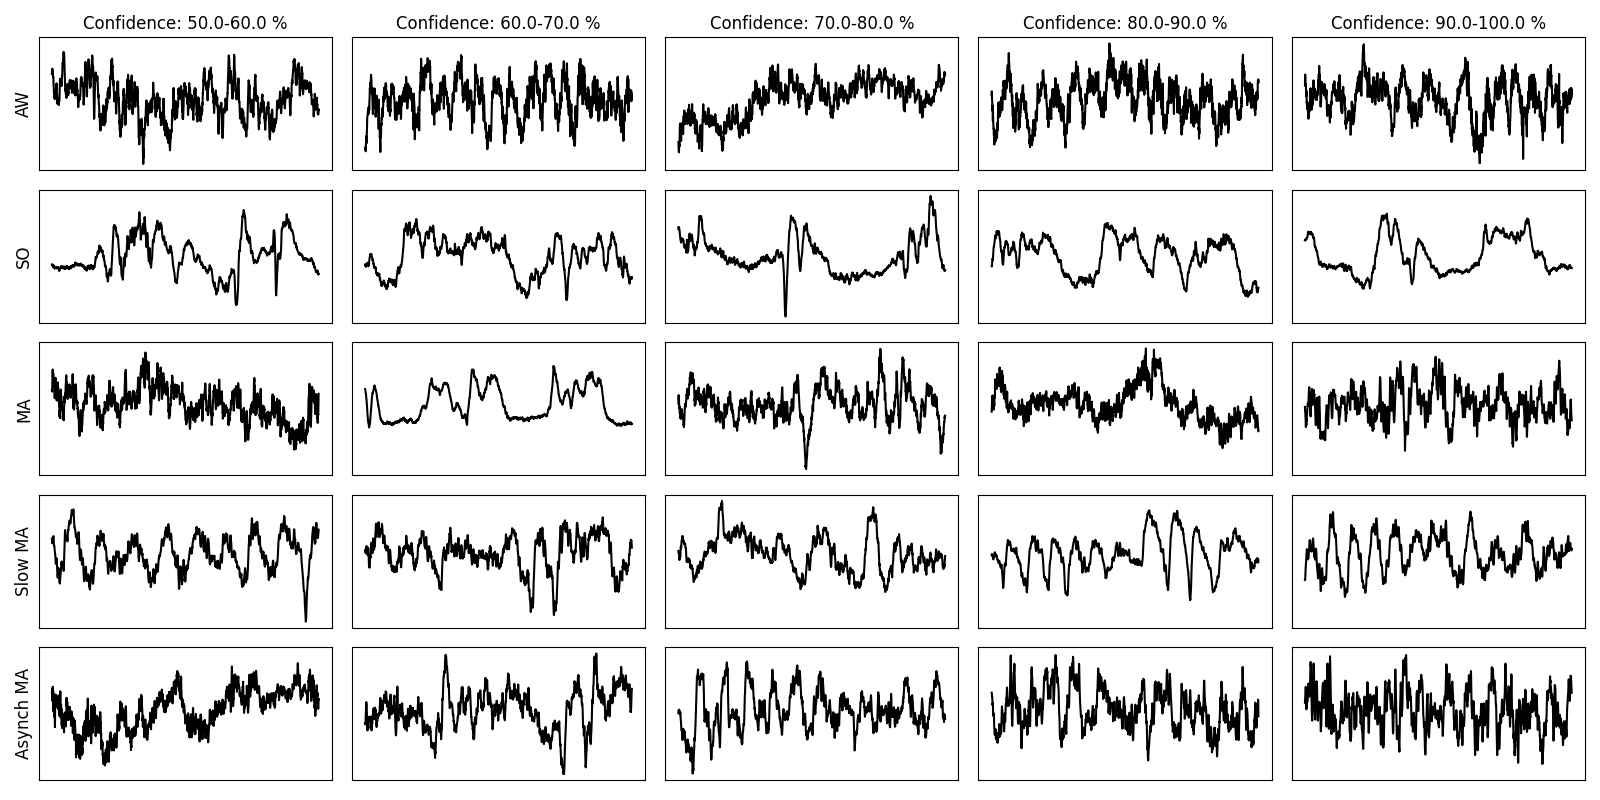

In [30]:
import os
import pickle
import pandas as pd
from IPython.display import clear_output
import scipy

name_testing_subject = 'Phoebe'
thresholds = np.arange(0.5, 1.0, 0.1)

# read dataframe for model 1
df_pred = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model1_{name_testing_subject}')

thr = [0.9, 0.9]
# load model 1 and 2
df_pred['y_prob'] = [df_pred['all_preds_prob'].iloc[p] if np.max(df_pred['prob'].iloc[p]) > thr[0] else -1 for p in range(len(df_pred['prob']))]
df_pred['prob_max'] = [np.max(df_pred['prob'].iloc[p]) for p in range(len(df_pred['prob']))]
df_mod2 = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model2_{name_testing_subject}')
predicted_classes = np.where(df_mod2['predictions'] > thr[1], 1, np.where(df_mod2['predictions'] <= 1 - thr[1], 0, -1)).flatten()

testing_data = np.load(f'testing_data/testing_data_{name_testing_subject}.npy')
testing_states = np.load(f'testing_data/testing_labels_{name_testing_subject}.npy')
data_test_MA = np.load(f'testing_data/testing_dataMA_{name_testing_subject}.npy')
labels_test_MA = np.load(f'testing_data/testing_labelsMA_{name_testing_subject}.npy')

fig, ax = plt.subplots(nrows=5, ncols=len(thresholds), figsize=(16, 8), sharey='row')
for tdx, threshold in enumerate(thresholds):
    thr = [threshold, threshold]

    # model 1 (AW, SO, MA)
    for sdx, state in enumerate([0, 1, 2]):
        # find indices fulfilling conditions of state and threshold bin
        state_indices = df_pred.loc[((df_pred['all_preds_prob']==state)&((df_pred['prob_max']>=threshold)&(df_pred['prob_max']<=(threshold+0.1))))].index.values
        # maybe some are empty
        if len(state_indices):
            # choose random indices
            selected_indices = np.random.choice(state_indices, 1)
            # loop and plot
            for seldx, selected in enumerate(selected_indices):
                ax[sdx, tdx].plot(scipy.stats.zscore(testing_data[selected, :]), c='k')
                ax[sdx, tdx].set_xticks([])
                ax[sdx, tdx].set_yticks([])
                if not sdx:
                    ax[sdx, tdx].set_title(f"Confidence: {np.round(100*threshold, 2)}-{np.round(100*(threshold+0.1),2)} %")
                
    # model 2 (slow_MA, asynch_MA)           
    state_indices_slowMA = df_mod2.loc[((df_mod2['y_pred']==1)&((df_mod2['predictions']>=threshold)&(df_mod2['predictions']<=threshold+0.1)))].index.values
    state_indices_asynchMA = df_mod2.loc[((df_mod2['y_pred']==0)&((df_mod2['predictions']<=1-threshold)&(df_mod2['predictions']>=1-threshold-0.1)))].index.values
    # maybe some are empty
    if len(state_indices_slowMA):
        # choose random indices
        selected_indices = np.random.choice(state_indices_slowMA, 1)
        # loop and plot
        for seldx, selected in enumerate(selected_indices):
            ax[3, tdx].plot(data_test_MA[selected, :], c='k')
            ax[3, tdx].set_xticks([])
            ax[3, tdx].set_yticks([])
    # maybe some are empty
    if len(state_indices_asynchMA):
        # choose random indices
        selected_indices = np.random.choice(state_indices_asynchMA, 1)
        # loop and plot
        for seldx, selected in enumerate(selected_indices):
            ax[4, tdx].plot(data_test_MA[selected, :], c='k')
            ax[4, tdx].set_xticks([])
            ax[4, tdx].set_yticks([])
            
ax[0, 0].set_ylabel('AW', fontsize=12)
ax[1, 0].set_ylabel('SO', fontsize=12)
ax[2, 0].set_ylabel('MA', fontsize=12)
ax[3, 0].set_ylabel('Slow MA', fontsize=12)
ax[4, 0].set_ylabel('Asynch MA', fontsize=12)
plt.tight_layout()

In [ ]:
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\confidence_traces.svg', dpi=600)

### Figure precision, recall and F1-score (taking into account UNKNOWNS)

<IPython.core.display.Javascript object>


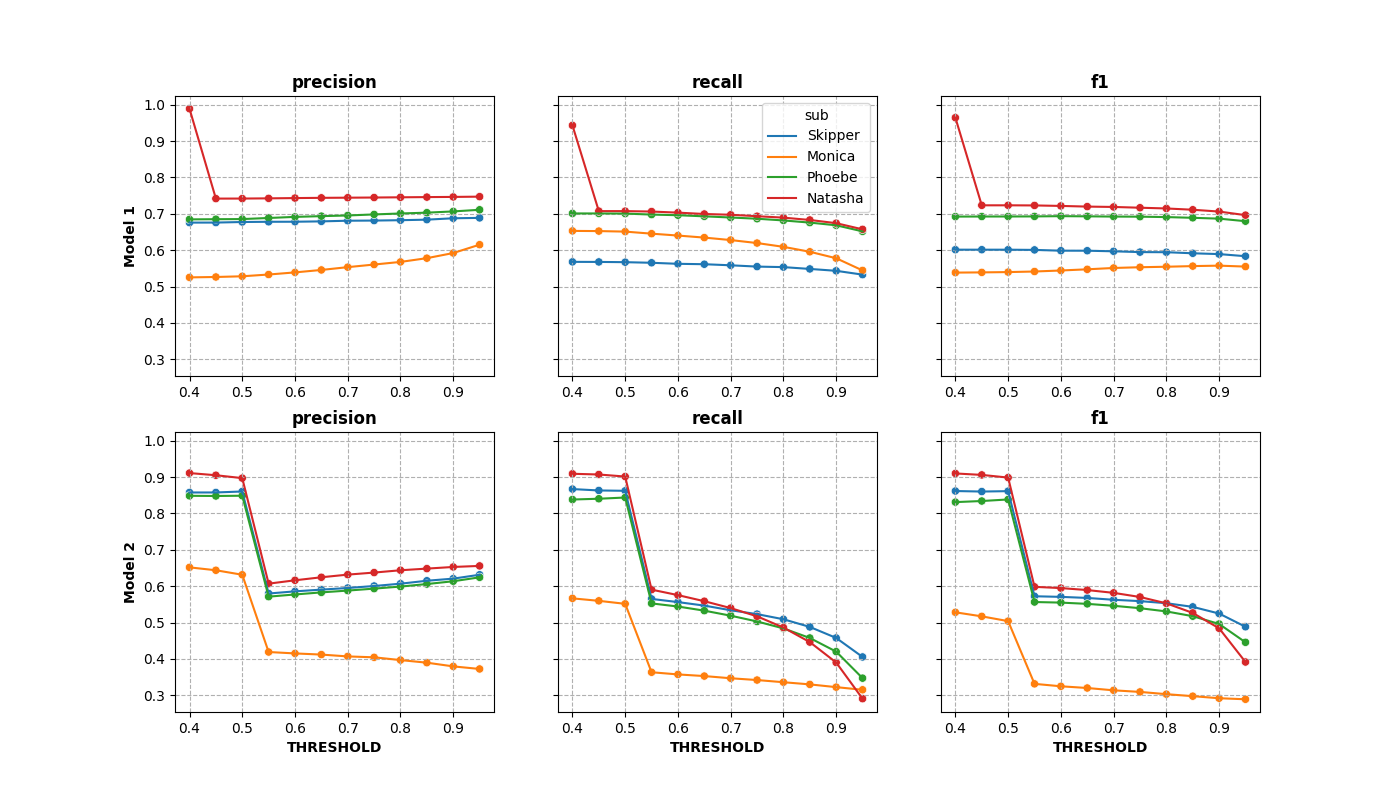

Text(0, 0.5, 'Model 2')

In [31]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 8), sharex=False, sharey=True)
for mdx, metric in enumerate(['precision', 'recall', 'f1']):
    leg_viz = True if mdx == 1 else False
    sns.lineplot(data=df_metrics.loc[df_metrics['model']==1], x='thr', y=metric, hue='sub', ax=ax[0, mdx], legend=leg_viz)
    sns.scatterplot(data=df_metrics.loc[df_metrics['model']==1], x='thr', y=metric, hue='sub', ax=ax[0, mdx], legend=False)
    ax[0, mdx].set_title(f'{metric}', fontweight='bold')
    ax[0, mdx].set_xlabel('')
    ax[0, mdx].grid(linestyle='--')

for mdx, metric in enumerate(['precision', 'recall', 'f1']):
    sns.lineplot(data=df_metrics.loc[df_metrics['model']==2], x='thr', y=metric, hue='sub', ax=ax[1, mdx], legend=False)
    sns.scatterplot(data=df_metrics.loc[df_metrics['model']==2], x='thr', y=metric, hue='sub', ax=ax[1, mdx], legend=False)
    ax[1, mdx].set_title(f'{metric}', fontweight='bold')
    ax[1, mdx].set_xlabel('THRESHOLD', fontweight='bold')
    ax[1, mdx].grid(linestyle='--')

ax[0, 0].set_ylabel('Model 1', fontweight='bold')
ax[1, 0].set_ylabel('Model 2', fontweight='bold')

### Figure precision, recall and F1-score (NOT taking into account UNKNOWNS)

<IPython.core.display.Javascript object>


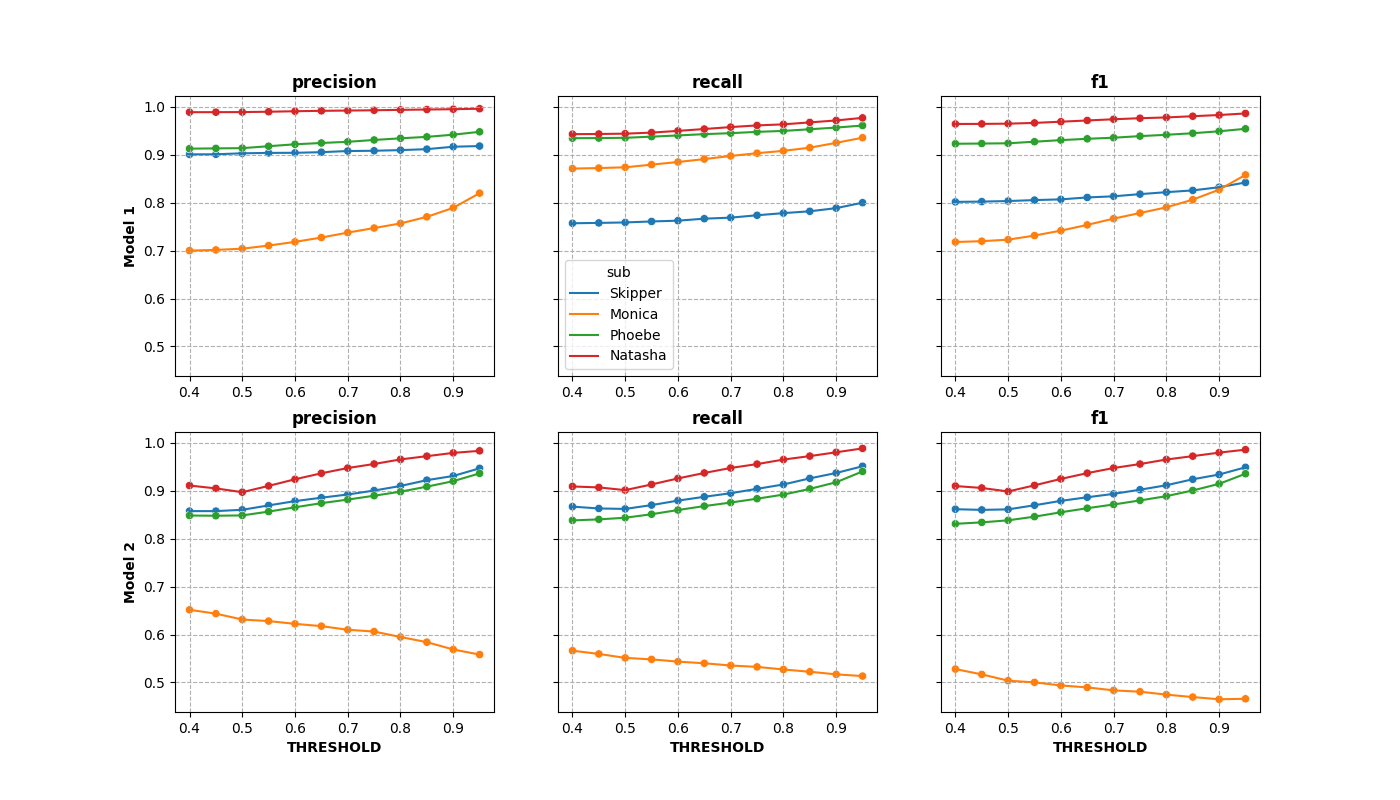

Text(0, 0.5, 'Model 2')

In [32]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 8), sharex=False, sharey=True)
for mdx, metric in enumerate(['precision', 'recall', 'f1']):
    leg_viz = True if mdx == 1 else False
    sns.lineplot(data=df_metrics_nounknown.loc[df_metrics['model']==1], x='thr', y=metric, hue='sub', ax=ax[0, mdx], legend=leg_viz)
    sns.scatterplot(data=df_metrics_nounknown.loc[df_metrics['model']==1], x='thr', y=metric, hue='sub', ax=ax[0, mdx], legend=False)
    ax[0, mdx].set_title(f'{metric}', fontweight='bold')
    ax[0, mdx].set_xlabel('')
    ax[0, mdx].grid(linestyle='--')

for mdx, metric in enumerate(['precision', 'recall', 'f1']):
    sns.lineplot(data=df_metrics_nounknown.loc[df_metrics['model']==2], x='thr', y=metric, hue='sub', ax=ax[1, mdx], legend=False)
    sns.scatterplot(data=df_metrics_nounknown.loc[df_metrics['model']==2], x='thr', y=metric, hue='sub', ax=ax[1, mdx], legend=False)
    ax[1, mdx].set_title(f'{metric}', fontweight='bold')
    ax[1, mdx].set_xlabel('THRESHOLD', fontweight='bold')
    ax[1, mdx].grid(linestyle='--')

ax[0, 0].set_ylabel('Model 1', fontweight='bold')
ax[1, 0].set_ylabel('Model 2', fontweight='bold')

In [ ]:
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\recall_prec_f1_withoutUNKNOWNS.svg', dpi=600)

### Figure: Accuracies of state dependant of the threshold

<IPython.core.display.Javascript object>


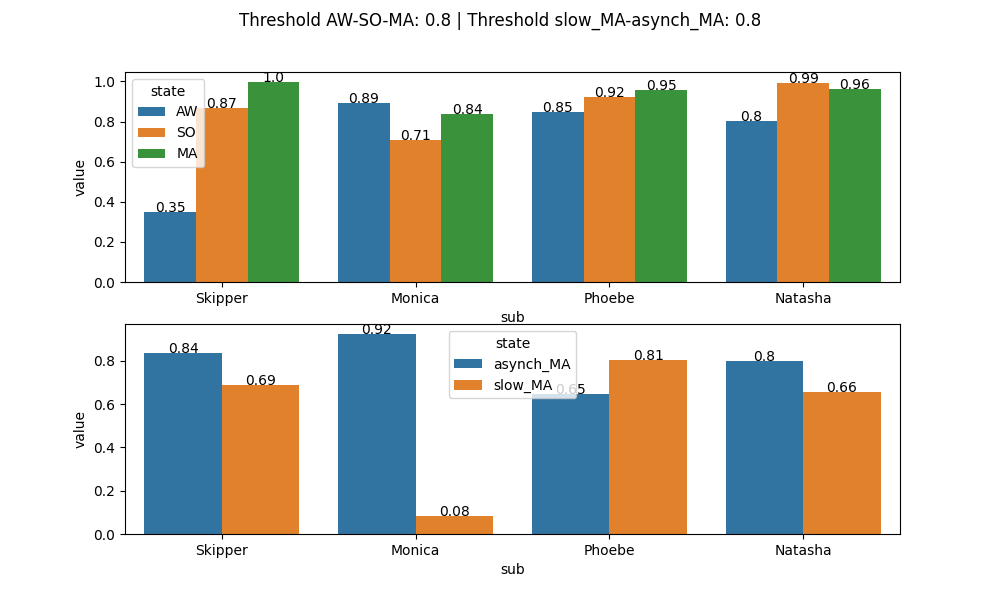

Text(0.5, 0.98, 'Threshold AW-SO-MA: 0.8 | Threshold slow_MA-asynch_MA: 0.8')

In [33]:
%matplotlib notebook
thr = [0.8, 0.8]
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))
bars = sns.barplot(data=df_acc.loc[((df_acc['state']!='unknown')&(df_acc['thr']==thr[0]))], x='sub', y='value', hue='state', ax=ax[0])
# Add the values on top of each bar
for p in bars.patches:
    ax[0].annotate(f'{np.round(p.get_height(), 2)}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
bars_MA = sns.barplot(data=df_acc_MA.loc[((df_acc_MA['state']!='unknown')&(df_acc_MA['thr']==thr[1]))], x='sub', y='value', hue='state', ax=ax[1])
# Add the values on top of each bar
for p in bars_MA.patches:
    ax[1].annotate(f'{np.round(p.get_height(), 2)}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    
fig.suptitle(f'Threshold AW-SO-MA: {thr[0]} | Threshold slow_MA-asynch_MA: {thr[1]}')

### Compute accuracy for only samples with prob > 0.9

In [ ]:
import pickle
from IPython.display import clear_output
df_acc90 = pd.DataFrame(columns=['sub','state', 'value'])
df_acc_MA90 = pd.DataFrame(columns=['sub','state', 'value'])

# define figure
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(14, 6), sharey='row')

# loop over testing subjects
for subdx, name_testing_subject in enumerate(names_to_test):

    # read df model 1
    df_pred = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model1_{name_testing_subject}')
    
    # get only those indices with prob above 0.9
    indices = [p for p in range(len(df_pred['prob'])) if np.max(df_pred['prob'].iloc[p]) > 0.9]

    # get samples above 90
    y90 = [df_pred['all_preds_prob'].iloc[p] for p in indices]
    real90 = [df_pred['all_labels_prob'].iloc[p] for p in indices]

    # compute confusion matrix
    cm = confusion_matrix(real90, y90, labels=[0, 1, 2])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["awake", "slow_updown", "MA states"],
                yticklabels=["awake", "slow_updown", "MA states"], 
                ax=ax[0, subdx], annot_kws={"size": 8}, cbar=False)
    
    ax[0, subdx].set_title(name_testing_subject)
    
    
    state_dict = {0: 'AW', 1: 'SO', 2: 'MA'}
    for i in state_dict.keys():
        # append to df
        df_acc90 = pd.concat([df_acc90, pd.DataFrame({
            'sub': name_testing_subject, 
            'state': state_dict[i], 
            'value': [cm_normalized[i, i]],
        })], ignore_index=True)


    # read df model 2
    df_mod2 = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model2_{name_testing_subject}')

    # threshold
    predicted_classes = np.where(df_mod2['predictions'] > 0.5, 1, np.where(df_mod2['predictions'] <= 1 - 0.5, 0, -1)).flatten()
    
    # get only those indices with prob above 0.9 or below 0.1
    indices = [p for p in range(len(df_mod2['predictions'])) if ((df_mod2['predictions'].iloc[p] > 0.9) or (df_mod2['predictions'].iloc[p] < 0.1))]
    
    # get samples above 90
    y90 = [predicted_classes[p] for p in indices]
    real90 = [df_mod2['true_classes'].iloc[p] for p in indices]

    cm = confusion_matrix(real90, y90, labels=[0, 1])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["asynch_MA", "slow_MA"],
                yticklabels=["asynch_MA", "slow_MA"], 
                ax=ax[1, subdx], annot_kws={"size": 8}, cbar=False)

    state_dict_mod2 = {0: 'asynch_MA', 1: 'slow_MA'}
    for i in state_dict_mod2.keys():
        # append to df
        df_acc_MA90 = pd.concat([df_acc_MA90, pd.DataFrame({
            'sub': name_testing_subject, 
            'state': state_dict_mod2[i], 
            'value': [cm_normalized[i, i]],
        })], ignore_index=True)
fig.suptitle('Accuracy for those samples with a probability > 90%')
plt.tight_layout()

### Check wrongly classified samples for the state of Microarousals (states: slow_Ma and asynch_MA)
- Plot all MA samples for each state and check which ones were badly classified projecting their spectral power over specific frequency bands

In [37]:
import pickle
from IPython.display import clear_output
from scipy.signal import welch as pwelch

suubs = ['Phoebe', 'Monica', 'Skipper', 'Natasha']
name_testing_subject = 'Phoebe'
POW = {}
for name_testing_subject in suubs:

    # read df model 2
    df_mod2 = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model2_{name_testing_subject}')

    # threshold
    predicted_classes = np.where(df_mod2['predictions'] > 0.5, 1, np.where(df_mod2['predictions'] <= 1 - 0.5, 0, -1)).flatten()

    # get only those indices with prob above 0.9
    indices = [p for p in range(len(df_mod2['predictions'])) if ((df_mod2['predictions'].iloc[p] > 0.9) or (df_mod2['predictions'].iloc[p] < 0.1))]

    POW[name_testing_subject] =  {}
    # get samples above 90
    y90 = [predicted_classes[p] for p in indices]
    real90 = [df_mod2['true_classes'].iloc[p] for p in indices]
    POW[name_testing_subject]['indices_bad0']= [p for p in indices if df_mod2['true_classes'].iloc[p] - predicted_classes[p] == -1] # true slow predicted asynch
    POW[name_testing_subject]['indices_bad1'] = [p for p in indices if df_mod2['true_classes'].iloc[p] - predicted_classes[p] == 1] # true asynch predicted slow
    POW[name_testing_subject]['indices_good0'] = [p for p in indices if df_mod2['true_classes'].iloc[p] - predicted_classes[p] == 0 and df_mod2['true_classes'].iloc[p] == 0] # true asynch
    POW[name_testing_subject]['indices_good1'] = [p for p in indices if df_mod2['true_classes'].iloc[p] - predicted_classes[p] == 0 and df_mod2['true_classes'].iloc[p] == 1] # true slow

    data = np.load(f'{os.getcwd()}/testing_data/testing_dataMA_{name_testing_subject}.npy')
    indicesMA = np.load(f'{os.getcwd()}/testing_data/testing_labelsMA_{name_testing_subject}.npy')
    
    fxx, pxx = pwelch(x=data, fs=1000, nfft=1000, nperseg=500, axis=1)
    
    bands = [[0.1, 4], [4, 8], [100, 500]]
    
    for bdx, band in enumerate(bands):
        POW[name_testing_subject][bdx] = np.log(np.mean(pxx[:, ((fxx>=band[0])&(fxx<=band[1]))], axis=1))
    
    POW[name_testing_subject]['data'] = data

<IPython.core.display.Javascript object>


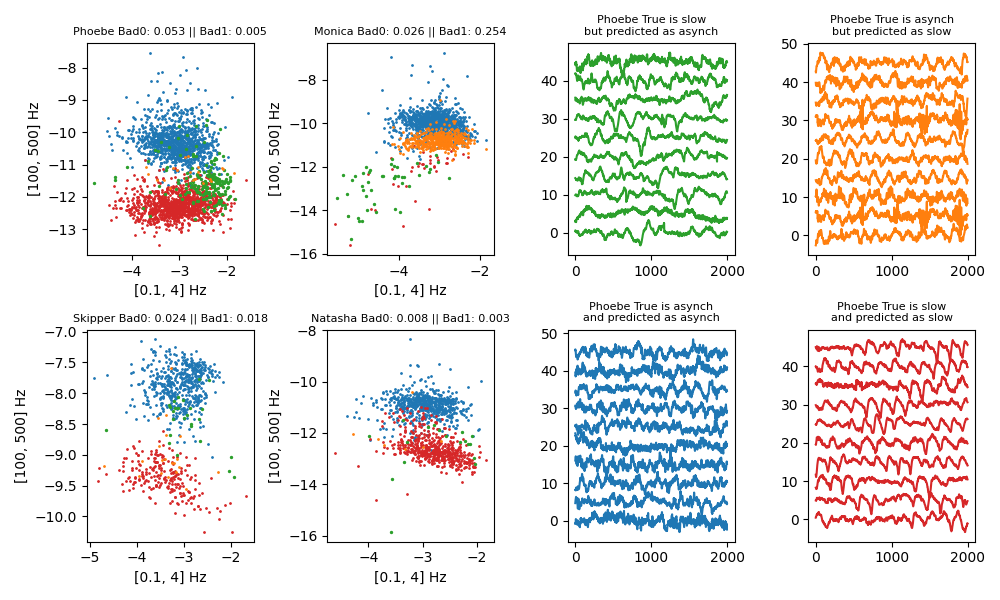

In [38]:
fig = plt.figure(figsize=(10, 6))
ax = [fig.add_subplot(241), #, projection='3d'), 
      fig.add_subplot(242), #, projection='3d'), 
      fig.add_subplot(245), #, projection='3d'), 
      fig.add_subplot(246), #, projection='3d'), 
      fig.add_subplot(243), 
      fig.add_subplot(244), 
      fig.add_subplot(247), 
      fig.add_subplot(248)]
bdxs = [0, 2]
ds_fac = 5
for pdx, sub in enumerate(POW.keys()):
#     ax[pdx].scatter(POW[sub][0][POW[sub]['indices_good0']], POW[sub][1][POW[sub]['indices_good0']], POW[sub][2][POW[sub]['indices_good0']], s=0.5, c='tab:blue')
#     ax[pdx].scatter(POW[sub][0][POW[sub]['indices_good1']], POW[sub][1][POW[sub]['indices_good1']], POW[sub][2][POW[sub]['indices_good1']], s=0.5, c='tab:red')
#     ax[pdx].scatter(POW[sub][0][POW[sub]['indices_bad0']], POW[sub][1][POW[sub]['indices_bad0']], POW[sub][2][POW[sub]['indices_bad0']], s=2, c='tab:green')
#     ax[pdx].scatter(POW[sub][0][POW[sub]['indices_bad1']], POW[sub][1][POW[sub]['indices_bad1']], POW[sub][2][POW[sub]['indices_bad1']], s=2, c='tab:orange')
    ax[pdx].scatter(POW[sub][bdxs[0]][POW[sub]['indices_good0']][::ds_fac], POW[sub][bdxs[1]][POW[sub]['indices_good0']][::ds_fac], s=1, c='tab:blue')
    ax[pdx].scatter(POW[sub][bdxs[0]][POW[sub]['indices_good1']][::ds_fac], POW[sub][bdxs[1]][POW[sub]['indices_good1']][::ds_fac], s=1, c='tab:red')
    ax[pdx].scatter(POW[sub][bdxs[0]][POW[sub]['indices_bad0']][::ds_fac], POW[sub][bdxs[1]][POW[sub]['indices_bad0']][::ds_fac], s=2, c='tab:green')
    ax[pdx].scatter(POW[sub][bdxs[0]][POW[sub]['indices_bad1']][::ds_fac], POW[sub][bdxs[1]][POW[sub]['indices_bad1']][::ds_fac], s=1, c='tab:orange')
    ax[pdx].set_title(f"{sub} Bad0: {np.round(len(POW[sub]['indices_bad0'])/len(POW[sub][0]), 3)} || Bad1: {np.round(len(POW[sub]['indices_bad1'])/len(POW[sub][0]), 3)}", fontsize=8)
    ax[pdx].set_xlabel(f"{bands[bdxs[0]]} Hz")
    ax[pdx].set_ylabel(f"{bands[bdxs[1]]} Hz")
    
sub = 'Phoebe'
num_samples = 10
for idx, i in enumerate(np.random.choice(POW[sub]['indices_bad0'], num_samples)):
    ax[4].plot(idx*5 + POW[sub]['data'][i], c='tab:green')
    ax[4].set_title(f'{sub} True is slow\nbut predicted as asynch', fontsize=8)
for idx, i in enumerate(np.random.choice(POW[sub]['indices_bad1'], num_samples)):
    ax[5].plot(idx*5 + POW[sub]['data'][i], c='tab:orange')
    ax[5].set_title(f'{sub} True is asynch\nbut predicted as slow', fontsize=8)
for idx, i in enumerate(np.random.choice(POW[sub]['indices_good0'], num_samples)):
    ax[6].plot(idx*5 + POW[sub]['data'][i], c='tab:blue')
    ax[6].set_title(f'{sub} True is asynch\nand predicted as asynch', fontsize=8)
for idx, i in enumerate(np.random.choice(POW[sub]['indices_good1'], num_samples)):
    ax[7].plot(idx*5 + POW[sub]['data'][i], c='tab:red')
    ax[7].set_title(f'{sub} True is slow\nand predicted as slow', fontsize=8)
plt.tight_layout()

<IPython.core.display.Javascript object>


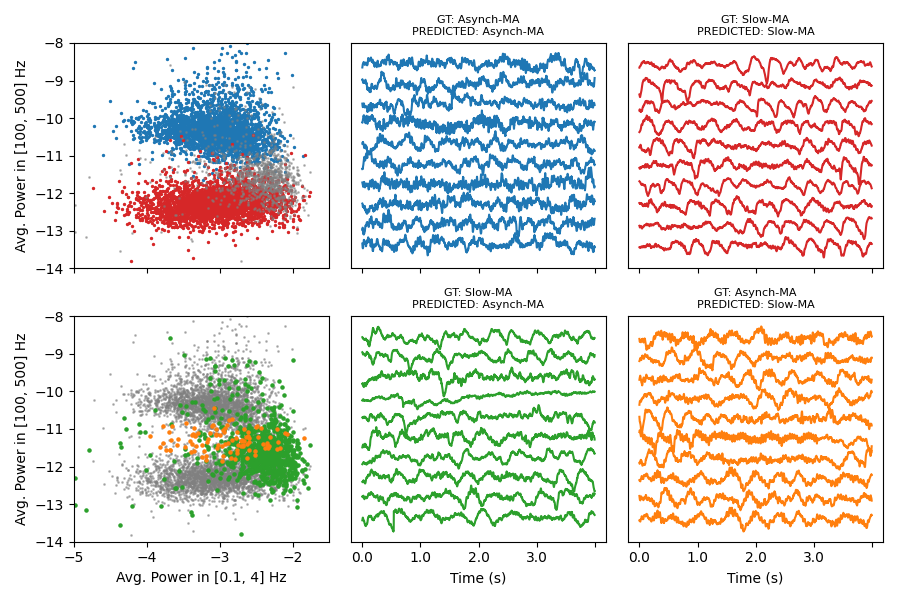

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


In [102]:
# Create a figure and a grid layout with 2 rows and 4 columns
fig, axs = plt.subplots(2, 3, figsize=(9, 6), sharex='col', sharey='col')
axs = axs.reshape(-1)
ax = [axs[1], axs[2], axs[4], axs[5]]
     
bdxs = [0, 2]
ds_fac = 2
sub = 'Phoebe'
axs[0].scatter(POW[sub][bdxs[0]][POW[sub]['indices_good0']][::ds_fac], POW[sub][bdxs[1]][POW[sub]['indices_good0']][::ds_fac], s=2, c='tab:blue')
axs[0].scatter(POW[sub][bdxs[0]][POW[sub]['indices_good1']][::ds_fac], POW[sub][bdxs[1]][POW[sub]['indices_good1']][::ds_fac], s=2, c='tab:red')
axs[0].scatter(POW[sub][bdxs[0]][POW[sub]['indices_bad0']][::1], POW[sub][bdxs[1]][POW[sub]['indices_bad0']][::1], s=1, c='gray', alpha=0.5)
axs[0].scatter(POW[sub][bdxs[0]][POW[sub]['indices_bad1']][::1], POW[sub][bdxs[1]][POW[sub]['indices_bad1']][::1], s=1, c='gray', alpha=0.5)
# axs[0].set_title(f"{sub} Bad0: {np.round(len(POW[sub]['indices_bad0'])/len(POW[sub][0]), 3)} || Bad1: {np.round(len(POW[sub]['indices_bad1'])/len(POW[sub][0]), 3)}", fontsize=8)
# axs[0].set_xlabel(f"Avg. Power in {bands[bdxs[0]]} Hz")
axs[0].set_ylabel(f"Avg. Power in {bands[bdxs[1]]} Hz")

axs[3].scatter(POW[sub][bdxs[0]][POW[sub]['indices_good0']][::ds_fac], POW[sub][bdxs[1]][POW[sub]['indices_good0']][::ds_fac], s=1, c='gray', alpha=0.5)
axs[3].scatter(POW[sub][bdxs[0]][POW[sub]['indices_good1']][::ds_fac], POW[sub][bdxs[1]][POW[sub]['indices_good1']][::ds_fac], s=1, c='gray', alpha=0.5)
axs[3].scatter(POW[sub][bdxs[0]][POW[sub]['indices_bad0']][::1], POW[sub][bdxs[1]][POW[sub]['indices_bad0']][::1], s=5, c='tab:green')
axs[3].scatter(POW[sub][bdxs[0]][POW[sub]['indices_bad1']][::1], POW[sub][bdxs[1]][POW[sub]['indices_bad1']][::1], s=5, c='tab:orange')
# axs[3].set_title(f"{sub} Bad0: {np.round(len(POW[sub]['indices_bad0'])/len(POW[sub][0]), 3)} || Bad1: {np.round(len(POW[sub]['indices_bad1'])/len(POW[sub][0]), 3)}", fontsize=8)
axs[3].set_xlabel(f"Avg. Power in {bands[bdxs[0]]} Hz")
axs[3].set_ylabel(f"Avg. Power in {bands[bdxs[1]]} Hz")
      
axs[0].set_xlim([-5, -1.5])
axs[0].set_ylim([-14, -8])
ax[0].set_yticks([]); ax[1].set_yticks([]); ax[2].set_yticks([]); ax[3].set_yticks([])
    
num_samples = 10
for idx, i in enumerate(np.random.choice(POW[sub]['indices_good0'], num_samples)):
    ax[0].plot(idx*5 + POW[sub]['data'][i], c='tab:blue')
    ax[0].set_title(f'GT: Asynch-MA\nPREDICTED: Asynch-MA', fontsize=8)
for idx, i in enumerate(np.random.choice(POW[sub]['indices_good1'], num_samples)):
    ax[1].plot(idx*5 + POW[sub]['data'][i], c='tab:red')
    ax[1].set_title(f'GT: Slow-MA\nPREDICTED: Slow-MA', fontsize=8)
for idx, i in enumerate(np.random.choice(POW[sub]['indices_bad0'], num_samples)):
    ax[2].plot(idx*5 + POW[sub]['data'][i], c='tab:green')
    ax[2].set_title(f'GT: Slow-MA\nPREDICTED: Asynch-MA', fontsize=8)
for idx, i in enumerate(np.random.choice(POW[sub]['indices_bad1'], num_samples)):
    ax[3].plot(idx*5 + POW[sub]['data'][i], c='tab:orange')
    ax[3].set_title(f'GT: Asynch-MA\nPREDICTED: Slow-MA', fontsize=8)
ax[2].set_xticklabels([np.round(i/1000, 1) for i in ax[2].get_xticks()])
ax[1].set_xticklabels([np.round(i/1000, 1) for i in ax[2].get_xticks()])
ax[2].set_xlabel('Time (s)')
ax[3].set_xlabel('Time (s)')
plt.tight_layout()

In [103]:
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\transitions_centroids.svg', dpi=600)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a grid layout with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Plot in the first position covering rows 0 and 1, and columns 0 and 1
ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)
ax1.plot(np.arange(10), np.random.randn(10))
ax1.set_title('Plot 1')

# Plot in the remaining positions
ax2 = axs[0, 2]
ax2.plot(np.arange(10), np.random.randn(10))
ax2.set_title('Plot 2')

ax3 = axs[0, 3]
ax3.plot(np.arange(10), np.random.randn(10))
ax3.set_title('Plot 3')

ax4 = axs[1, 2]
ax4.plot(np.arange(10), np.random.randn(10))
ax4.set_title('Plot 4')

ax5 = axs[1, 3]
ax5.plot(np.arange(10), np.random.randn(10))
ax5.set_title('Plot 5')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Get number of samples for each state

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharex=True, sharey=False)
ax = ax.reshape(-1)
sdx = 0
for file in os.listdir(os.getcwd() + '/testing_data'):
    if file.startswith('testing_labels'):
        testing_labels = np.load(os.getcwd() + '/testing_data/' + file)
        # Count the occurrences of each unique element
        unique_elements = sorted(list(set(testing_labels)))
        counts = [list(testing_labels).count(element) for element in unique_elements]       
        ax[sdx].bar(unique_elements, counts)
        for c in range(len(unique_elements)):
            ax[sdx].text(c-0.4, counts[c], str(np.round(100*counts[c]/len(testing_labels), 2))+'%')
        ax[sdx].set_title(file.split('_')[2].split('.')[0])       
        ax[sdx].set_xticklabels(unique_elements, rotation=45)
        sdx += 1

plt.tight_layout()

### Classification of new channels 
- Classify new channels (same structure than best_ch)
- Compare detection with the best_ch

In [ ]:
imp.reload(fx)
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
import gc
pattern = '*.pkl'
matching_files = glob.glob(pattern)
names_dict = {}
times_dict = {}

for file_path in matching_files:
    file_name = file_path.split("/")[-1]
    NAME = file_path.split('_')[0]
    TIME = file_path.split('_')[1]  # Remove the file extension
    if NAME not in names_dict:
        names_dict[NAME] = []
    if NAME not in times_dict:
        times_dict[NAME] = []
    names_dict[NAME].append(TIME)
    times_dict[NAME].append(TIME)

    
name_time_list = []
for name, times in times_dict.items():
    for time in times:
        name_time_list.append((name, time))
        
names_to_test = set([i for i,_ in name_time_list])

for name_testing_subject in names_to_test:
    print(f'================={name_testing_subject}=================')
    try: 
        del data, testing_data, testing_states
        gc.collect()
    except:
        pass

    
    print('Organizing data...')
    
    for name, time in name_time_list:
        if name == name_testing_subject:
            # read data to extract not best_ch channels
            data = pd.read_pickle(f"{name}_{time}_fullrec.pkl")
            # define not best_ch channels
            ch_labels = [ch_label for ch_label in data['labels'] if ch_label != data['best_ch']]
            break

    # loop over ch_labels
    for ch_label in ch_labels:
        print(f'Analyzing {ch_label}...')
        
        testing_data = []; testing_states = []
        
        for name, time in name_time_list:
            if name == name_testing_subject:
                #read data
                data, states = fx.read_data_and_metadata(name, time, best_channel=ch_label)
                
                # append in case more than one session for the subject
                testing_data.append(data)
                testing_states.extend(states)

        testing_data = np.concatenate(testing_data, axis=0)
        
#         np.save(f'testing_data/testing_data_{name_testing_subject}_ch_{ch_label}.npy', testing_data[:, ::10]) # saving every 10 steps to reduce memory consumption
        model = fx.CNN()
        model_path = f"models_trainmain/primary_model_epoch_{name_testing_subject}_6.pth"
        model.load_state_dict(torch.load(model_path))
        print(f"Loaded model from {model_path}")

        test_data_normalized = fx.normalize_data(testing_data)
        test_labels_numeric = fx.labels_to_numbers(testing_states)
        test_dataset = TensorDataset(torch.tensor(test_data_normalized, dtype=torch.float32).unsqueeze(1),
                                     torch.tensor(test_labels_numeric, dtype=torch.long))
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        all_preds, all_labels = [], []
        all_preds_prob, all_labels_prob = [], []
        probs = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                probabilities = F.softmax(outputs, dim=1)
                _, preds_prob = torch.max(probabilities, 1)
                all_preds_prob.extend(preds_prob.cpu().numpy())
                all_labels_prob.extend(labels.numpy())
                probs.append(list(probabilities.numpy()[0]))

        df_pred = pd.DataFrame({'all_preds_prob': all_preds_prob, 'all_labels_prob': all_labels_prob, 'prob': probs})
        df_pred.to_pickle(f'model_df_probs/df_pred_model1_{name_testing_subject}_ch_{ch_label}')        

        treshold_mod2 = 0.85
        y_pred, predictions, true_classes, data_test_MA, labels_test_MA = fx.mod2_onlypredict(name_testing_subject, testing_data, testing_states, treshold_mod2, norm=True) 

#         np.save(f'testing_data/testing_dataMA_{name_testing_subject}_ch_{ch_label}.npy', data_test_MA[:, ::10]) # saving every 10 steps to reduce memory consumption

        
        # apppend to dataframe
        df_pred = pd.DataFrame({'y_pred': y_pred.reshape(1, -1)[0], 'predictions': predictions.reshape(1, -1)[0], 'true_classes': true_classes})
        df_pred.to_pickle(f'model_df_probs/df_pred_model2_{name_testing_subject}_ch_{ch_label}')    

### Compute differences in prediction of best channel and not best-channel (AW - SO - MA)

In [ ]:
df_pred_ch
cm = confusion_matrix(df_pred_ch['true_classes'], df_pred_ch['y_pred'], labels=[0, 1])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
# heatmap
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=["asynch_MA", "slow_MA"],
            yticklabels=["asynch_MA", "slow_MA"], 
            annot_kws={"size": 8}, cbar=False)
plt.show()

In [ ]:
df_ch = pd.DataFrame(columns=['sub', 'ch', 'diff', 'model'])
df_ch_good_det_only = pd.DataFrame(columns=['sub', 'ch', 'diff', 'model'])

# loop over subjects
for name_testing_subject in names_to_test:
    
    # get not best_ch channels
    channels = [i.split(f'{name_testing_subject}_ch_')[1] for i in os.listdir(os.getcwd() + '/model_df_probs') if i.startswith(f'df_pred_model1_{name_testing_subject}_ch')]
    
    for num_model in range(1, 3):
        # read best channel dataframe
        df_pred_best = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model{num_model}_{name_testing_subject}')
        if num_model == 2:
            df_pred_best['all_preds_prob'] = df_pred_best['y_pred']
            df_pred_best['all_labels_prob'] = df_pred_best['true_classes']

        for ch in channels:
            # for all detections
            # read channel
            df_pred_ch = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model{num_model}_{name_testing_subject}_ch_{ch}')
            if num_model == 2:
                df_pred_ch['all_preds_prob'] = df_pred_ch['y_pred']

            # compute difference
            diff = len(np.where(df_pred_best['all_preds_prob'].values - df_pred_ch['all_preds_prob'].values != 0)[0]) / len(df_pred_best['all_preds_prob'].values)

            # append to dataframe
            df_ch = pd.concat([df_ch, pd.DataFrame({
               'sub': name_testing_subject,
                'ch': ch, 
                'diff': [100*diff], 
                'model': [num_model], 
            })], ignore_index=True)

            # for only those good detections
            # find indices of good classification in best channel
            indices = np.where(df_pred_best['all_preds_prob'].values - df_pred_best['all_labels_prob'].values == 0)[0]

            # compute difference
            diff = len(np.where(df_pred_best['all_preds_prob'].values[indices] - df_pred_ch['all_preds_prob'].values[indices] != 0)[0]) / len(indices)

            # append to dataframe
            df_ch_good_det_only = pd.concat([df_ch_good_det_only, pd.DataFrame({
               'sub': name_testing_subject,
                'ch': ch, 
                'diff': [100*diff], 
                'model': [num_model], 
            })], ignore_index=True)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(14, 6), sharey=True)
for ndx, name_testing_subject in enumerate(names_to_test):
    sns.barplot(data=df_ch.loc[df_ch['sub']==name_testing_subject], x='ch', y='diff', hue='model', ax=ax[0, ndx])
    ax[0, ndx].set_title(name_testing_subject)
    if ndx==0:
        ax[0, 0].set_ylabel('Percentage (%) of different \nclassification with best_channel')
    else:
        ax[0, ndx].set_ylabel('')
    unique_elements = sorted(list(set(df_ch.loc[df_ch['sub']==name_testing_subject, 'ch'])))
    ax[0, ndx].set_xticklabels(unique_elements, rotation=45)
    ax[0, ndx].grid(linestyle='--')
    
    sns.barplot(data=df_ch_good_det_only.loc[df_ch_good_det_only['sub']==name_testing_subject], x='ch', y='diff', hue='model', ax=ax[1, ndx])
    ax[1, ndx].set_title(name_testing_subject)
    if ndx==0:
        ax[1, 0].set_ylabel('Percentage (%) of different \nclassification with best_channel\n only good detections')
    else:
        ax[1, ndx].set_ylabel('')
    unique_elements = sorted(list(set(df_ch_good_det_only.loc[df_ch['sub']==name_testing_subject, 'ch'])))
    ax[1, ndx].set_xticklabels(unique_elements, rotation=45)
    ax[1, ndx].grid(linestyle='--')
plt.tight_layout()

### Check which channel

In [ ]:
# files = ['testing_dataMA_Phoebe', 'testing_dataMA_Phoebe_ch_PtA_R', 'testing_dataMA_Phoebe_ch_S1_R6', 'testing_dataMA_Phoebe_ch_V1_R']
files = ['testing_data_Smith', 'testing_data_Smith_ch_Au2_A', 'testing_data_Smith_ch_M1_A', 'testing_data_Smith_ch_PrL_A']; model = 1
# files = ['testing_dataMA_Natasha', 'testing_dataMA_Natasha_ch_PrL_A', 'testing_dataMA_Natasha_ch_Au2_A', 'testing_dataMA_Natasha_ch_PtA_A']; model = 2
sig = {}
pred = {}
for file in files: 
    sig[file] = np.load(os.getcwd() + f'/testing_data/{file}.npy')
    pred[file] = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model{model}_{file.split("data_")[1]}')

In [ ]:
import scipy.stats
fig, ax = plt.subplots(ncols=4, figsize=(14, 4), sharey=True)
idx = np.random.choice(sig[file].shape[0])
for fdx, file in enumerate(files):
    ax[fdx].plot(scipy.stats.zscore(sig[file][idx, :]))
    if fdx == 0:
        ax[fdx].set_title('Pred: ' + str(pred[file]["all_preds_prob"].iloc[idx]) + 'True: ' + str(pred[file]["all_labels_prob"].iloc[idx]) + ' Prob: ' + str(np.round(max(pred[file]["prob"].iloc[idx]), 2)))
    else:
        ax[fdx].set_title('Pred: ' + str(pred[file]["all_preds_prob"].iloc[idx]) + ' Prob: ' + str(np.round(max(pred[file]["prob"].iloc[idx]), 2)))

### Compute direction of wrong classifications based on best_ch as true (AW-SO-MA)

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=7, figsize=(16, 12))

# loop over subjects
for ndx, name_testing_subject in enumerate(names_to_test):
    
    # get not best_ch channels
    channels = [i.split(f'{name_testing_subject}_ch_')[1] for i in os.listdir(os.getcwd() + '/model_df_probs') if i.startswith(f'df_pred_model1_{name_testing_subject}_ch')]
    
    for num_model in range(1, 2):
        # read best channel dataframe
        df_pred_best = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model{num_model}_{name_testing_subject}')
        if num_model == 2:
            df_pred_best['all_preds_prob'] = df_pred_best['y_pred']
            df_pred_best['all_labels_prob'] = df_pred_best['true_classes']

        for cdx, ch in enumerate(channels):
            # for all detections
            # read channel
            df_pred_ch = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model{num_model}_{name_testing_subject}_ch_{ch}')
            if num_model == 2:
                df_pred_ch['all_preds_prob'] = df_pred_ch['y_pred']
                
            indices = np.where(df_pred_best['all_preds_prob'].values - df_pred_best['all_labels_prob'].values == 0)[0]

            cm = confusion_matrix(df_pred_best['all_labels_prob'][indices], df_pred_ch['all_preds_prob'][indices], labels=[0, 1, 2])
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            # heatmap
            sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                        xticklabels=["AW", "SO", "MA"],
                        yticklabels=["AW", "SO", "MA"], 
                        ax=ax[cdx, ndx], annot_kws={"size": 8}, cbar=False)
            
            ax[cdx, ndx].set_ylabel(ch)
            if cdx==0:
                ax[cdx, ndx].set_title(name_testing_subject)

plt.tight_layout()
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\CM_all_subjects_all_nonbestchannels_model1.jpg')

### Compute direction of wrong classifications based on best_ch as true (MA)

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=7, figsize=(16, 12))

# loop over subjects
for ndx, name_testing_subject in enumerate(names_to_test):
    
    # get not best_ch channels
    channels = [i.split(f'{name_testing_subject}_ch_')[1] for i in os.listdir(os.getcwd() + '/model_df_probs') if i.startswith(f'df_pred_model1_{name_testing_subject}_ch')]
    
    for num_model in range(2, 3):
        # read best channel dataframe
        df_pred_best = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model{num_model}_{name_testing_subject}')
        if num_model == 2:
            df_pred_best['all_preds_prob'] = df_pred_best['y_pred']
            df_pred_best['all_labels_prob'] = df_pred_best['true_classes']

        for cdx, ch in enumerate(channels):
            # for all detections
            # read channel
            df_pred_ch = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model{num_model}_{name_testing_subject}_ch_{ch}')
            if num_model == 2:
                df_pred_ch['all_preds_prob'] = df_pred_ch['y_pred']
                
            indices = np.where(df_pred_best['all_preds_prob'].values - df_pred_best['all_labels_prob'].values == 0)[0]

            cm = confusion_matrix(df_pred_best['all_labels_prob'][indices], df_pred_ch['all_preds_prob'][indices], labels=[0, 1])
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            # heatmap
            sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                        xticklabels=["asynch_MA", "slow_MA"],
                        yticklabels=["asynch_MA", "slow_MA"], 
                        ax=ax[cdx, ndx], annot_kws={"size": 8}, cbar=False)
            
            ax[cdx, ndx].set_ylabel(ch)
            if cdx==0:
                ax[cdx, ndx].set_title(name_testing_subject)

plt.tight_layout()
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\CM_all_subjects_all_nonbestchannels_model2.jpg')

In [ ]:
a = np.load('C:\\Users\\manasanch.IBP10386\\Desktop\\ANESTHESIA_LEVELS\\DATA\\DATA_LIVEPAPER\\RAW TRANSITIONS\\full_recordings\\oneoverf\\exp1f_Phoebe_210626.npy', allow_pickle=True)
a['exp1f']